## TSNE of BERT representations for each language

In [1]:
%load_ext autoreload
%autoreload 2
import torch
from transformers import BertModel
from offenseval.nn import (
    Tokenizer,
    train, evaluate, train_cycle, save_model, load_model
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model, TEXT = load_model("../../models/bert.cased.sample.mean06.ft.pt", device)

bert_model = BertModel.from_pretrained("bert-base-multilingual-cased").to(device)


/home/jmperez/.local/share/virtualenvs/offenseval2020-HKdlw5Be/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'transformers.modeling_bert.BertModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [35]:
from torchtext import data
import pandas as pd
from tqdm.autonotebook import tqdm


def get_bert_ouputs(model, TEXT, test_path, batch_size=32):
    """
    High level function that evaluates a model on a given dataset

    Arguments:
    ---------

    model: Pytorch Module
        An already trained model

    TEXT: torchtext.data.Field
        Field for the "TEXT" field.

    test_path: path to a .csv

        The dataset must contain the following columns
            - id
            - text/tweet
            - subtask_a (label NOT or OFF)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Loading dataset...")
    ID = data.Field(sequential=False, use_vocab=False)
    SUBTASK_A = data.LabelField()

    test_dataset = data.TabularDataset(
        test_path,
        format="tsv", skip_header=True,
        fields=[("id", ID), ("text", TEXT),
                ("subtask_a", SUBTASK_A)],
    )
    SUBTASK_A.build_vocab(test_dataset)

    assert SUBTASK_A.vocab.itos == ["NOT", "OFF"]

    print("Building iterators")

    test_it = data.BucketIterator(
        test_dataset, batch_size=batch_size, device=device,
        sort_key = lambda x: len(x.text), sort_within_batch = True,
    )
    
    # Get the tokenizer to reconvert ids to tokens
    tokenizer = TEXT.tokenize.__self__
    bert_tokenizer = tokenizer.bert_tokenizer

    # OBSERVATION: Do not compare this loss with the one of the training!
    # This has no class weights
    with torch.no_grad():
        ret = []
        for batch in tqdm(test_it):
            text, lens = batch.text
            out = model(text)[1]

            for pooled_output, target, token_ids in zip(out, batch.subtask_a, text):
                ret.append({
                    "pooled_output": pooled_output.cpu().numpy(),
                    "subtask_a": target.item(),
                    "text": " ".join(bert_tokenizer.convert_ids_to_tokens(token_ids)),
                })

    return ret


In [43]:
files = [
    ('english', "../../data/olid/test_a.tsv"),
    ('danish', "../../data/Danish/dev.tsv"),
    ('greek', "../../data/Greek/dev.tsv"),
    ('turkish', "../../data/Turkish/dev.tsv"),
    ('arabic', "../../data/Arabic/offenseval-ar-dev-v1.tsv"),
]

dfs = []

for lang, path in files:
    print(f"Calculating BERT pooled outputs for {lang}")
    bert_outs = get_bert_ouputs(
        model.bert, TEXT, path
    )

    lang_df = pd.DataFrame(bert_outs)
    lang_df["lang"] = lang
    
    dfs.append(lang_df)


df = pd.concat(dfs)

Calculating BERT pooled outputs for english
Loading dataset...
Building iterators



Calculating BERT pooled outputs for danish
Loading dataset...
Building iterators



Calculating BERT pooled outputs for greek
Loading dataset...
Building iterators



Calculating BERT pooled outputs for turkish
Loading dataset...
Building iterators



Calculating BERT pooled outputs for arabic
Loading dataset...
Building iterators


In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

X = np.vstack(df["pooled_output"])
# First, apply dimensionality reduction with PCA
pca = PCA(100)
X_pca = pca.fit_transform(X)
# Then, use TSNE
tsne = TSNE(2)
X_emb = tsne.fit_transform(X_pca)

df["x"] = X_emb[:, 0]
df["y"] = X_emb[:, 1]


## Plotting all together

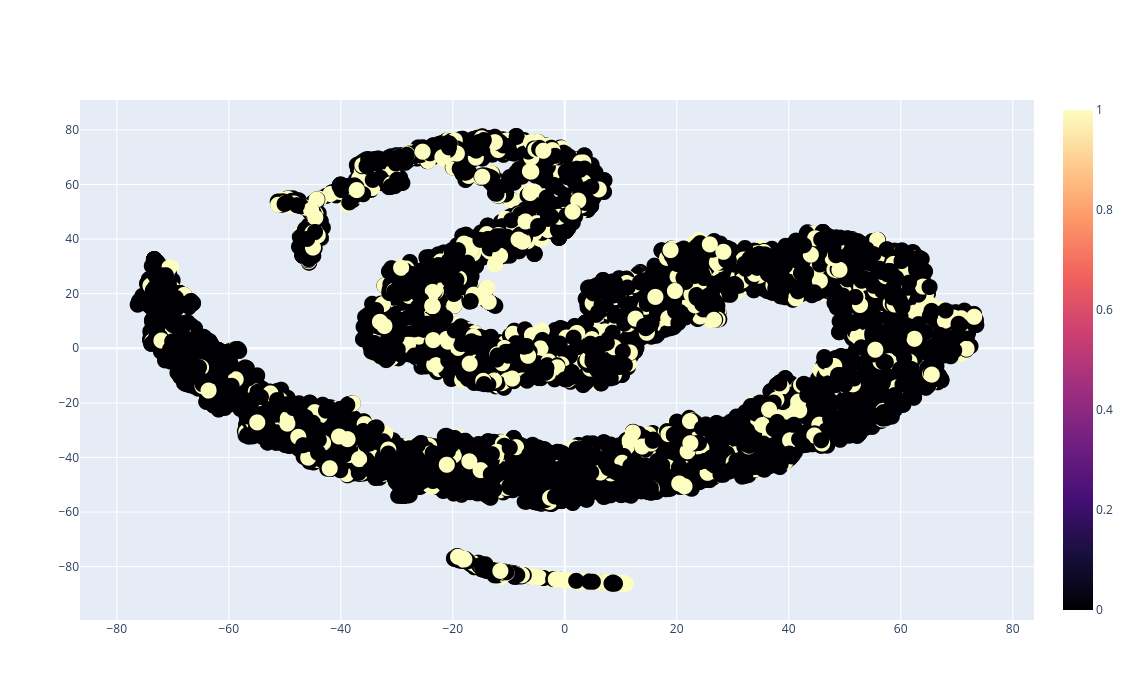

In [49]:
import plotly.graph_objects as go

def scatter_plot(df):
    fig = go.Figure(data=go.Scatter(
        x=df["x"], 
        y=df["y"],
        text=df["text"],
        mode='markers',
        marker=dict(
            size=16,
            color=df["subtask_a"], #set color equal to a variable
            colorscale='Magma', # one of plotly colorscales
            showscale=True)
    ))


    fig.update_layout(
        autosize=False,
        width=700,
        height=700,
    )

    fig.show()
    
scatter_plot(df)

## Just English

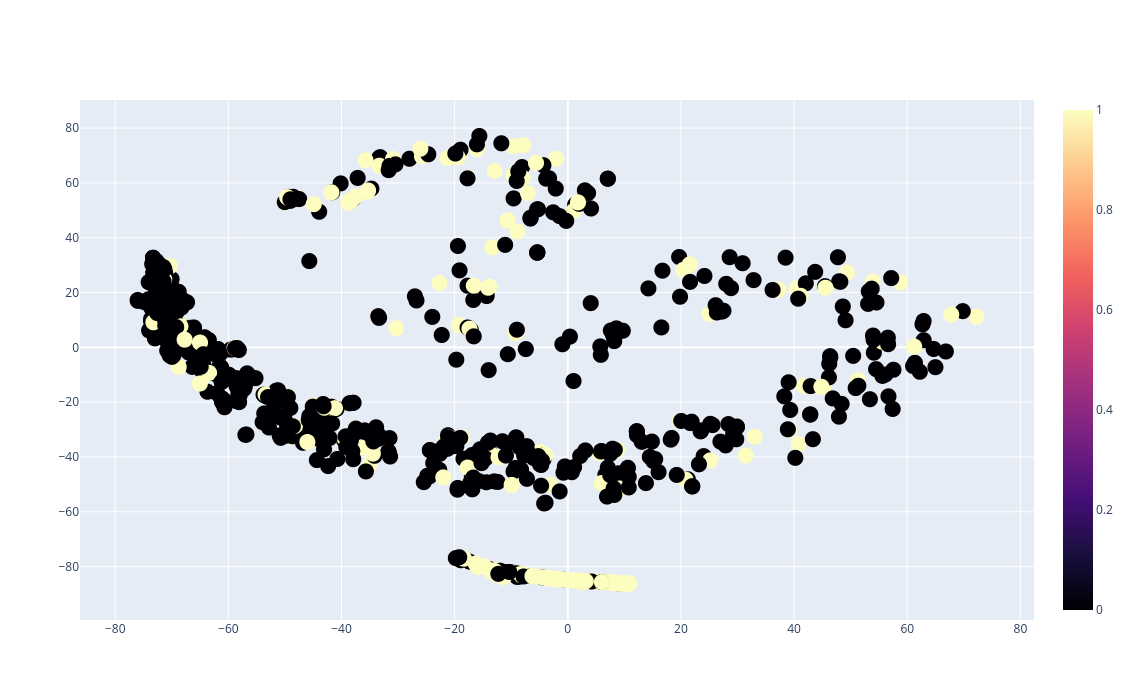

In [50]:
scatter_plot(df[df["lang"] == "english"])

## Plotting with Seaborn (if Plot.ly not working)

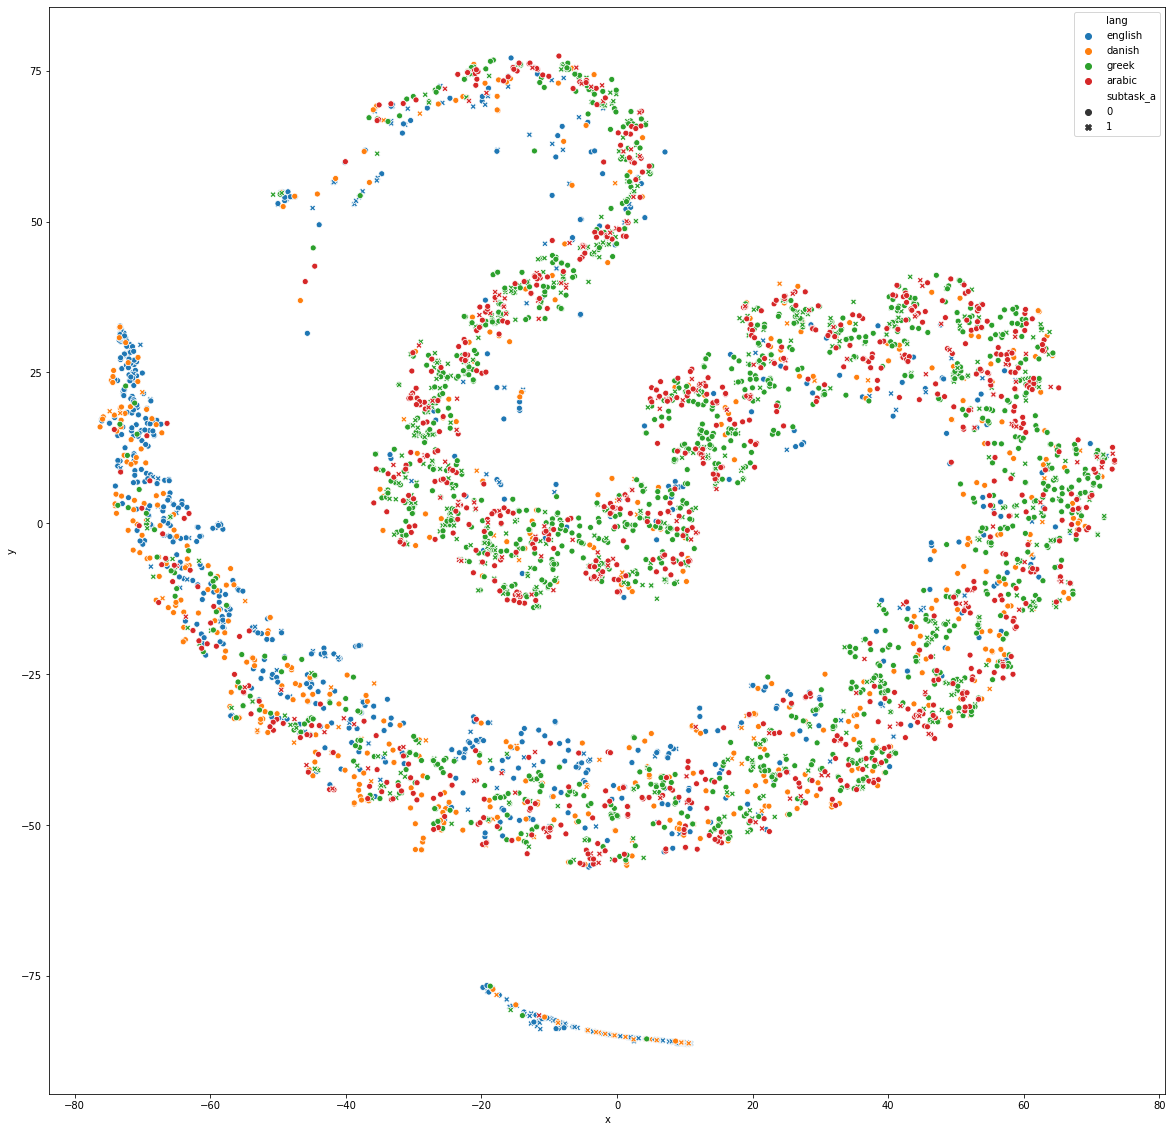

In [53]:
%matplotlib inline
import plotly.graph_objects as go
import seaborn as sns

from matplotlib import pyplot as plt

plt.figure(figsize=(20,20))
sub_df = df[df["lang"] != "turkish"]

sns.scatterplot(x="x", y="y", data=sub_df,
                style="subtask_a", hue="lang")

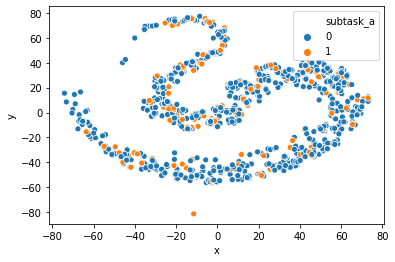

In [55]:
import seaborn as sns

sub_df = df[df["lang"] == "arabic"]

sns.scatterplot(x="x", y="y", hue="subtask_a", data=sub_df)